# Discrete logarithm problem

This problem arises in many fields in cryptography and this is why it is worth having a quick look on it. Roughly speaking is the problem of finding $k$ such that $a^k$(mod $p$)=$n$ where we know $a$ and $p$. This may seem a super simple problem (if we don't work in the modulo operation but in plain real numbers we use the logarithm for that) but as we will see finding $k$ is a brute force task. 


First of all we have to choose a  prime number $p$ 

In [1]:
from crypt import RandomPrime
from crypt import isPrime
from crypt import PrimesSieveEratosthenes

from random import seed
seed(2)

bits = 16
# p is a large prime number
p = RandomPrime(bits)  
print("is p={} a large prime number? {}".format(p, isPrime(p, 40)))
print(f"Generating all primes smaller than {1<<bits}")
primes = list(PrimesSieveEratosthenes(1<<bits))

We also need a generator for such a prime

In [2]:
from crypt import PrimeFieldGenerator

g = PrimeFieldGenerator(p, primes)

print("g = {} is a generator of the field F_{}".format(g, p))

g = 32191 is a generator of the field F_61981


We then know that $g$ is going to generate all the numbers in the field. We know that since $p$ is prime, all numbers from 1 to $p-1$ are invertible and so we can generate all numbers by powering $g$. Just as a matter of check, we find the number of invertible elements:

In [3]:
from crypt import InvertibleNumbers

invertible = len(InvertibleNumbers(p))
print("Number of inverible elements is {} wich should be {} if p is prime".format(invertible, p-1))

Number of inverible elements is 61980 wich should be 61980 if p is prime


We require to calculate large integer powers, for instance 23456^99999 (mod $p$), this will blow our computer!. One way to calculate this could be multiplying 23456 by itself 99999 times and apply the operation (mod $p$) every time we multiply but this turns out to be still slow. A better way is the fast powering algorithm (see [An Introduction to Mathematical Cryptography](https://www.springer.com/gp/book/9781493917105)). 

In [4]:
from crypt import fastPowering

Now we choose the secret, we will take $k=1234$. So $g^k$(mod p) is:

In [5]:
k = 1234
gkp = fastPowering(g, k, p)

print(gkp)

59510


In [6]:
print("g = {}\nk = {}\ng^k = a = {}".format(g, k, gkp))

g = 32191
k = 1234
g^k = a = 59510


Now the attacker receives the quantity $a=g^k$(mod p) and the task is to check for which $k$ we get a. Now by brute force mode let's try to find all the values $k$ that satisfy $a=g^k$(mod p)

In [7]:
for i in range(1, p-1):
    a = fastPowering(g,i,p)
    if a==gkp:
        print("k={}, a={}".format(i, a))

k=1234, a=59510


We found the right one!. This case has been fast but as the prime number becomes larger this time increases a lot. In order to see the difficulty of the problem let me plot all the values of $a$ for different $k$s

<Figure size 432x288 with 0 Axes>

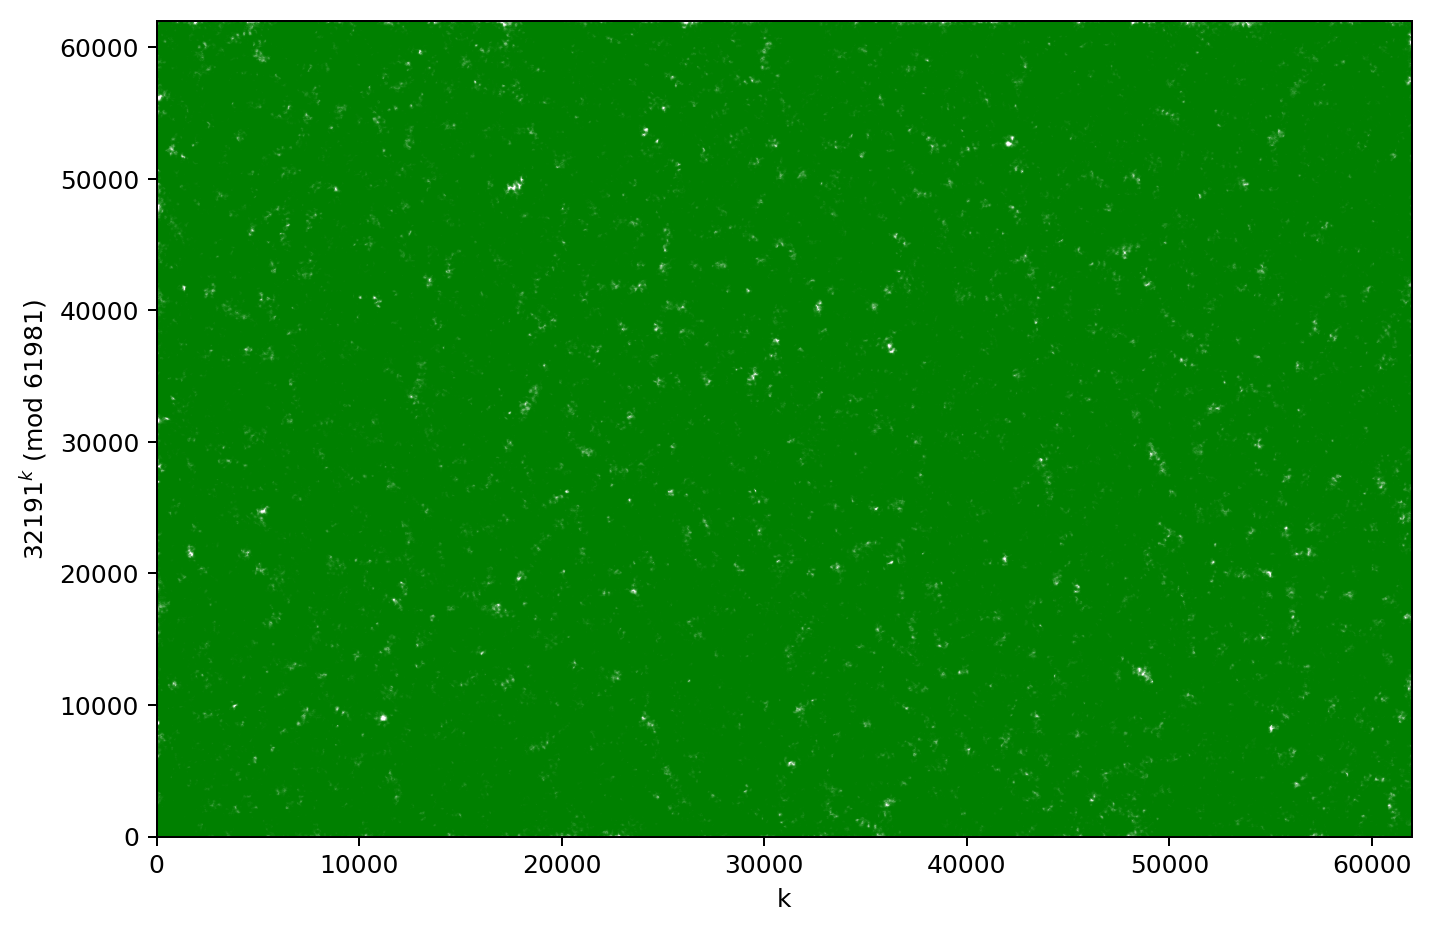

In [8]:
x, y = [], []

for i in range(1, p-1):
    x.append(i)
    y.append(fastPowering(g,i,p))

import matplotlib.pyplot as plt
%matplotlib inline

plt.clf()
fig=plt.figure(dpi = 180, figsize=(9,6))

plt.scatter(x, y, c="g", alpha=0.5, marker=r'$\bigstar$',
            label="")
plt.xlabel("k")
plt.ylabel("${}^k$ (mod ${}$)".format(g, p))
#plt.legend(loc='upper right')
plt.ylim((0, p))
plt.xlim((0, p-1))
plt.show()

As you can see this seems random... In fact it is unpredictable. Let me show a zoom of this graph for values of $k$ between 2000 and 3000 and with lines to see the randomicity.

<Figure size 432x288 with 0 Axes>

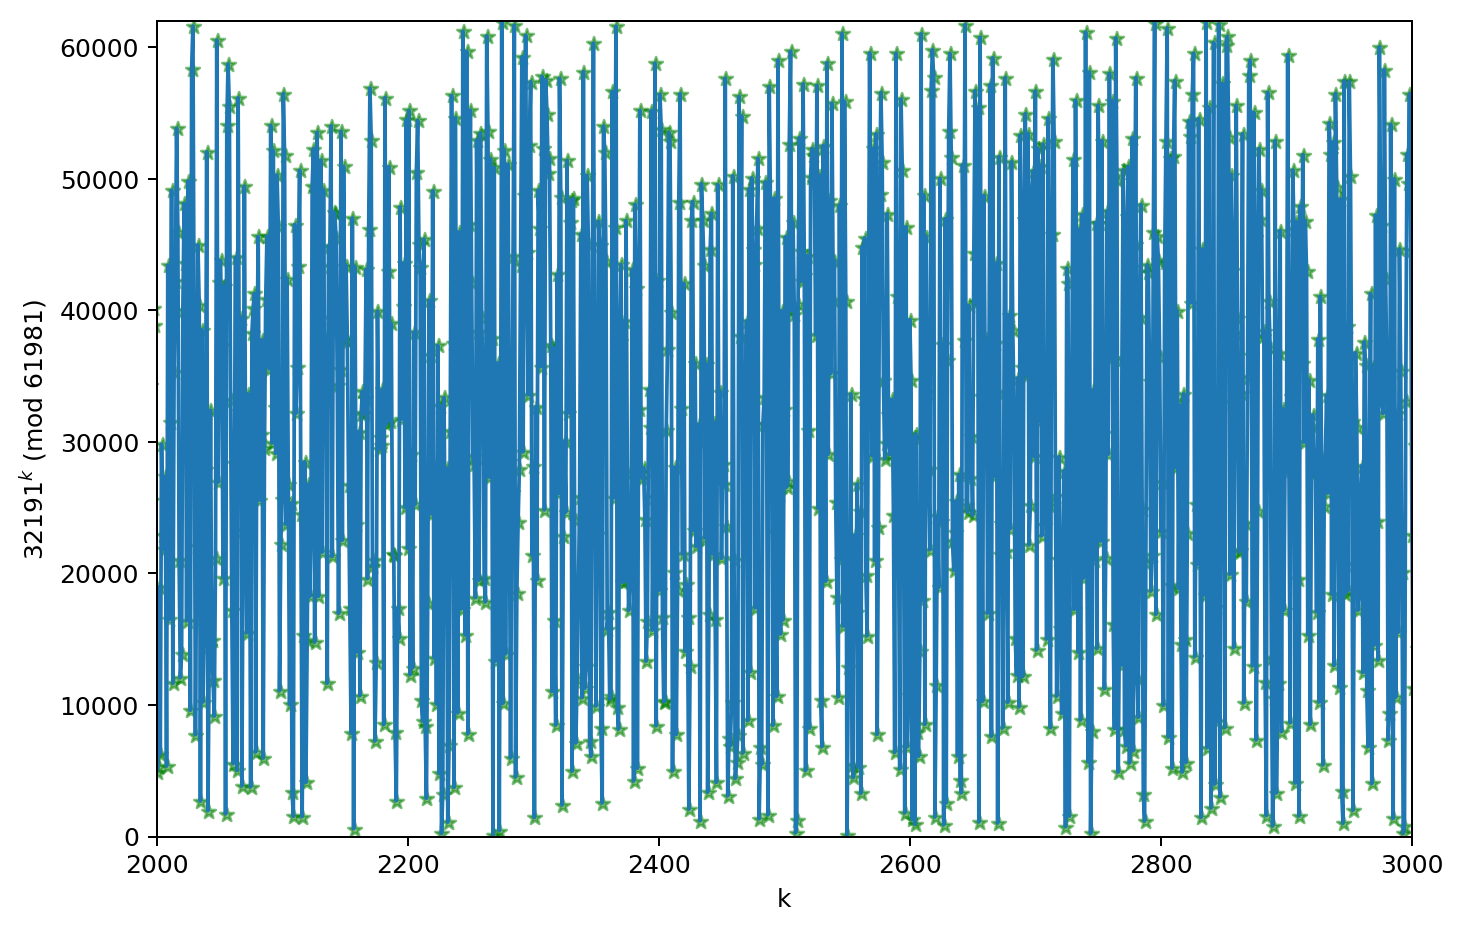

In [9]:
plt.clf()
fig=plt.figure(dpi = 180, figsize=(9,6))

plt.scatter(x, y, c="g", alpha=0.5, marker=r'$\bigstar$',
            label="")
plt.plot(x, y)
plt.xlabel("k")
plt.ylabel("${}^k$ (mod ${}$)".format(g, p))
#plt.legend(loc='upper right')
plt.ylim((0, p))
plt.xlim((2000, 3000))
plt.show()

This is very chaotic and thus the attacker has to options, either check from beginning to end to find the value of $k$ or sample values of $k$ randomly to check. Hard task to perform for large $p$.

The solution $n$ is not unique, i.e. there is more than one $k$ such that $g^k$(mod $p$)=$a$. We can see that from Fermat's litte therorem $g^{p-1}=1$(mod $p$) for $p$ prime, hence if $k$ is a solution then $k+\phi(p-1)$ is also a solution, where $\phi$ is an natural number.

Let's check this with same $g=627$ and $p=941$ exploring $k$ until 99999.

In [10]:
a = 627
p = 941

x = list()
y = list()

for i in range(0, 99999):
    x.append(i)
    y.append(fastPowering(a,i,p))

Let's see for which $k$s we get the same number $n$

In [11]:
#define the function to calculate the next k with same n
k2 = lambda x: k + x*(p-1)

for i in range(1,8):
    k = k2(i)
    print("k={}, n={}".format(x[i], y[i]))

k=1, n=627
k=2, n=732
k=3, n=697
k=4, n=395
k=5, n=182
k=6, n=253
k=7, n=543


# Diffie-Hellman key exchange

[Diffie-Hellman key exchange](https://en.wikipedia.org/wiki/Diffie%E2%80%93Hellman_key_exchange) is a method of securely exchanging cryptographic keys over a public channel and was one of the first public-key protocols as originally conceptualized by Ralph Merkle and named after Whitfield Diffie and Martin Hellman. Diffie-Hellman is one of the earliest practical examples of public key exchange implemented within the field of cryptography. The algorithm is best described in page 66 of [An introduction to mathematical cryptography](https://www.springer.com/gp/book/9781441926746).

We begin with Alice and bob agreeing in a prime number $p$ and a generator of the multiplicative field $g$:

In [12]:
p = RandomPrime(bits)  
print("is p={} a large prime number? {}".format(p, isPrime(p, 40)))

g = PrimeFieldGenerator(p, primes)
print("g={} is a generator of the field F_{}".format(g, p))

is p=49627 a large prime number? True
g=49181 is a generator of the field F_49627


Alice and bob choose a secret value $a$ and $b$ respectively:

In [13]:
from random import randrange

a, b = randrange(2, p), randrange(2, p)

print("Secret for Alice a={}".format(a))
print("Secret for Bob b={}".format(b))

Secret for Alice a=22981
Secret for Bob b=14458


Alice computes $A=g^a$ and Bob $B=g^b$

In [14]:
A = fastPowering(g, a, p)
B = fastPowering(g, b, p)

print("Secret power for Alice A={}".format(A))
print("Secret power for Bob B={}".format(B))

Secret power for Alice A=20389
Secret power for Bob B=16996


Now Alice sends Bob A and Bob sends Alice B using an insecure channel. Alice then computes $B^a$ and Bob $A^b$ so that they have the same key

In [15]:
sk_Alice = fastPowering(B, a, p)
sk_Bob = fastPowering(A, b, p)

print("Final secret key for Alice {}".format(sk_Alice))
print("Final secret key for Bob {}".format(sk_Bob))

Final secret key for Alice 41621
Final secret key for Bob 41621


Now they've been able to calculate the same key secretly. How is that so? The only information that an attacker can infer from looking into communication is $p$ and $g$ from the agreement and the shared values $A$, $B$. They never share the exponents $a$ or $b$, the ones that will be difficult to guess according to the discrete logarithm problem (if $p$ is sufficiently large).

DH is used mainly to agree a private key for two parties where the comunications can be compromised